# Self-Driving Car Nanodegree
## Project 4: Advanced Lane Finding

In [13]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from math import atan2, hypot # angle and dist
import os
%matplotlib inline
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Reading Image

In [14]:
#reading in an image
images=[]
fns=[]
path = "test_images/"
cnt=0
for fn in os.listdir(path):
    print(cnt, 'Image File:', fn)
    cnt+=1
    image = mpimg.imread(path+fn)
    images.append(image)
    fns.append(fn)
print(image.shape)
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imsh
    #plt.show()

0 Image File: test3.jpg
1 Image File: test1.jpg
2 Image File: test5.jpg
3 Image File: straight_lines2.jpg
4 Image File: test4.jpg
5 Image File: test2.jpg
6 Image File: test6.jpg
7 Image File: straight_lines1.jpg
(720, 1280, 3)


test1.jpg


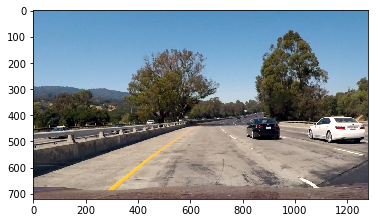

In [15]:
idx = 1
print(fns[idx])
plt.imshow(images[idx])

# Pipe line modules

## 0. Parameters

In [16]:
def GetParameters():
    return {'CameraCalibrationFile': './cam_calib.p',
                's_thresh':(170, 255), 
                'h_thresh':(42, 80), 
                'sx_thresh':(20, 100),
                'Perspect_hx1': 548, 
                'Perspect_hx2': 736, 
                'Perspect_hy': 461, #the y of the horizon
                'Perspect_offset': 200,
                'ROI_hx1': 629, 
                'ROI_hx2': 680,
                'ROI_bx1': 0, 
                'ROI_bx2': 1269,              
                'ROI_hy':419,
                'Fit_MinPoints': 150,
                'Fit_ClearOut': (500, 800),
                'Fit_MinCurvature': 500,
                'Fit_PositionTolerence': 100,
                'Fit_WidthTolerence': 100,
                'Fit_WindowSize': 10,
                'Fit_ValueThreshold': 0.02,
                'Fit_std': 0.05
             }
Parameters = GetParameters()

## 1. Camera Undistort

In [17]:
import pickle

dist_pickle = pickle.load(open(Parameters['CameraCalibrationFile'], "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def CamUndistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

## 2. Color and gradient thresholding

In [18]:
def Thresholding(img):
    s_thresh=Parameters['s_thresh']
    h_thresh=Parameters['h_thresh']
    sx_thresh=Parameters['sx_thresh']    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:, :, 0]
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold color channel
    #l_binary = np.zeros_like(l_channel)
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((sxbinary, s_binary, h_binary))
    
    #merge =np.logical_or( 
    #        np.logical_or(sxbinary, s_binary), 
    #        np.logical_and(h_binary, l_binary))
    
    return color_binary

## 3. Region of Interest

In [19]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def ROI(img):
    imshape = img.shape
    horizon_x1, horizon_x2 = Parameters['ROI_hx1'], Parameters['ROI_hx2']
    bottom_x1, bottom_x2 = Parameters['ROI_bx1'], Parameters['ROI_bx2']
    horizon_y = Parameters['ROI_hy']
    vertices = np.array([[(bottom_x1,imshape[0]),(horizon_x1, horizon_y), (horizon_x2, horizon_y), 
                          (bottom_x2,imshape[0])]], dtype=np.int32)
    return region_of_interest(img, vertices)

## 4. Perspect Transform

In [20]:
def PerspectiveTransform(img):    
    y, x = img.shape[0], img.shape[1]    
    hx1, hx2 = Parameters['Perspect_hx1'], Parameters['Perspect_hx2']
    hy = Parameters['Perspect_hy']   #the horizon
    offset = Parameters['Perspect_offset']
    src = np.float32([[hx1, hy], [hx2, hy], [0, y-1], [x-1, y-1]])    
    dst = np.float32([[offset, 0], [x-1-offset, 0], [offset, y-1], [x-1-offset, y-1]])   
    #print(src)
    #print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (x, y), flags=cv2.INTER_LINEAR)
    # convert to gray scale
    gray = np.mean(warped, axis=2)        
    return gray, M

In [89]:
870/1270*700

479.5275590551181

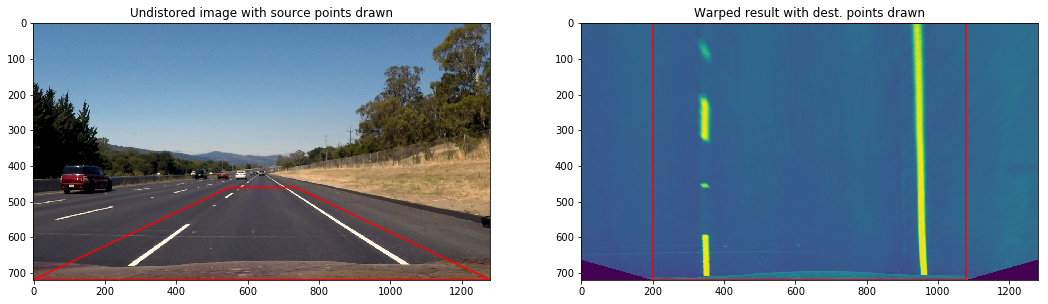

In [21]:
src = np.array([[  548.,   461.],
 [  736.,   461.],
 [ 1279.,   719.],
 [    0.,   719.],[  548.,   461.]
 ])

dst = np.array([[  200.,     0.],
 [ 1079.,     0.], [ 1079. ,  719.], [  200.,   719.],[  200.,     0.]           ])

image = images[3]
undist = CamUndistort(image) 
warped, M = PerspectiveTransform(undist)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.plot(src[:,0],src[:,1], 'r')
plt.title('Undistored image with source points drawn')
plt.subplot(1,2,2)
plt.imshow(warped)
plt.plot(dst[:,0],dst[:,1], 'r')
plt.title('Warped result with dest. points drawn')

## 5. Tracking Lanes

In [98]:
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error

def FindPeakInSegment(S, window_size=200):
    m, n = S.shape    
    hist = np.mean(S, axis=0)    
    ghist = gaussian_filter1d(hist, 40)        
    midx = int(n/2)
    lp = np.argmax(ghist[:midx])
    rp = np.argmax(ghist[midx:])+midx-1        
    return lp, rp, ghist

def CheckTopNoise(PA, center, diffth = 50):
    start = 0
    for i in range(1, PA.shape[0]):
        if PA[i,1]>300:
            break
        xdiff = abs(PA[i,0]-PA[i-1,0])
        if xdiff>diffth:
            if abs(PA[i-1,0]-center)>abs(PA[i,0]-center):
                start=i
                break
    return PA[start:]
            

def LanePointsSelection(gray, width):
    m, n = gray.shape
    pos_tol = Parameters['Fit_PositionTolerence'] #100
    width_tol = Parameters['Fit_WidthTolerence'] #100
    ws = Parameters['Fit_WindowSize'] #10
    th = Parameters['Fit_ValueThreshold'] #0.02
    LPS = [] # left lane points 
    RPS = [] # right lane points    
    gray[:, Parameters['Fit_ClearOut'][0]:Parameters['Fit_ClearOut'][1]]=0
    lc, rc, _ = FindPeakInSegment(gray)
    midx = int((lc+rc)/2)
    #print('Left center:', lc)
    #print('Right center:', rc)
    for cy in range(ws, m-ws):
        S = gray[cy-ws: cy+ws, :]        
        lp, rp, ghist = FindPeakInSegment(S)    
        lstd = np.std(ghist[:midx])
        rstd = np.std(ghist[midx:])    
        #if cy==200:
        #    print('right std:', cy, rstd)
        #    plt.plot(ghist)
        lv, rv = ghist[lp], ghist[rp]        
        if lv>th and rv>th:
            if abs((rp-lp)-width) > width_tol:
                continue            
        if lv>th and abs(lp-lc)<pos_tol: #position tolerence - diff to line center 
            if lstd<Parameters['Fit_std']:
                LPS.append([lp, cy])                        
        if rv>th and abs(rp-rc)<pos_tol:
            if rstd<Parameters['Fit_std']:
                RPS.append([rp, cy])     
    LPA = np.array(LPS) # left point array
    RPA = np.array(RPS) # right point array
    LPA = CheckTopNoise(LPA, lc)
    RPA = CheckTopNoise(RPA, rc)
    return LPA, RPA

def DrawPoints(gray, LPA, RPA):
    plt.figure(figsize=(10,10))
    plt.imshow(gray, cmap='bone')
    if LPA.shape[0]>0:
        plt.plot(LPA[:,0], LPA[:,1],'.r')
    if RPA.shape[0]>0:
        plt.plot(RPA[:,0], RPA[:,1],'.g')
    
class Line():
    def __init__(self, singleFrameMode=False):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        imgy = 720
        self.fity = np.linspace(0, imgy-1, imgy)
        self.x_tolerence = 200
        self.singleFrameMode = singleFrameMode
        self.err = None #MSE from raw points

    def AddFittedLine(self, fitx, fit, curv, PA):        
        self.detected = True
        if not self.singleFrameMode:
            if not(self.best_fit is None):
                if abs(fitx[-1]-self.best_fit[-1])>self.x_tolerence:                    
                    self.detected = False                    
        else:
            self.detected = True
        if PA.shape[0]<Parameters['Fit_MinPoints']: #too little fitting points            
            self.detected = False 
        if curv<Parameters['Fit_MinCurvature']: #reject if curature is too small            
            self.detected = False 
        if not self.detected:
            return
        self.recent_xfitted.append(fitx)
        if len(self.recent_xfitted)>20:
            self.recent_xfitted.pop(0)
        XS = np.array(self.recent_xfitted)
        self.bestx = np.mean(XS, axis=0)
        self.best_fit = np.polyfit(self.fity, self.bestx, 2)        
        if not (self.current_fit is None):
            self.diffs = fit - self.current_fit
        self.current_fit = fit
        self.radius_of_curvature = curv
        self.line_base_pos = self.current_fit[-1]
        self.allx = PA[:,0]
        self.ally = PA[:,1]
        fitx_raw = fit[0]*self.ally**2 + fit[1]*self.ally + fit[2]
        
    
def TrackingLanes(gray, vis=True):    
    
    lp, rp, hist = FindPeakInSegment(gray)
    #plt.plot(hist)
    width = rp - lp
    #print('Estimated Width:', width)
    
    LPA, RPA = LanePointsSelection(gray, width)
            
    if vis==True:
        DrawPoints(gray, LPA, RPA)
       
    # Fit a second order polynomial to each
    ploty = np.linspace(0, gray.shape[0]-1, gray.shape[0])
    # Get Curvature
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/width # meters per pixel in x dimension
    
    if LPA.shape[0]>0:
        leftx = LPA[:,0]
        lefty = LPA[:,1]
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_XS.append(left_fitx) #debug use
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        LeftLine.AddFittedLine(left_fitx, left_fit, left_curverad, LPA)
    else:
        LeftLine.detected = False
        left_curvrad = None
    
    if RPA.shape[0]>0:
        rightx = RPA[:,0]
        righty = RPA[:,1]
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_XS.append(right_fitx)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        RightLine.AddFittedLine(right_fitx, right_fit, right_curverad, RPA)
    else:
        RightLine.detected = False
        right_curverad = None
    
    if vis==True:
        print('Estimated width (pixel):', width, 'Left Curvature:', left_curverad, 'm', 
          'Right Curvature:', right_curverad, 'm')
        if LeftLine.detected:
            plt.plot(left_fitx, ploty, color='yellow')
        else:
            print('Left line is not detected with confidence.')
        
        plt.plot(right_fitx, ploty, color='yellow')
        if RightLine.detected:
            plt.plot(right_fitx, ploty, color='yellow')
        else:
            print('Right line is not detected with confidence.')
    

## 6. Validate and inference lanes 

In [99]:
# Depending on golbal variables LeftLine, RightLine
def ValidateAndInferenceLanes():
    if LeftLine.detected:
        left_fitx = LeftLine.recent_xfitted[-1]

    if not LeftLine.detected:        
        left_fitx = LeftLine.bestx
        
    if RightLine.detected:
        right_fitx = RightLine.recent_xfitted[-1]
        
    if not RightLine.detected:
        right_fitx = RightLine.bestx
    return left_fitx, right_fitx    
    

## 7. Lane visualization

In [111]:
# Depending on golbal variables LeftLine, RightLine
def DrawingLaneCarpet(warped, undist, M, vis=True, font_color = (255,255,255)):    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
    left_fitx, right_fitx = ValidateAndInferenceLanes()
    
    if left_fitx is None or right_fitx is None:
        return None
    
    ploty = LeftLine.fity
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)    
    
    curv=(LeftLine.radius_of_curvature + RightLine.radius_of_curvature )/2.0
    xm_per_pixel = 3.7 / (RightLine.line_base_pos+LeftLine.line_base_pos)
    offset=abs(result.shape[1]/2.0 - (RightLine.line_base_pos+LeftLine.line_base_pos)/2.0) * xm_per_pixel    
    curv_text = 'Curvature: '+str(round(curv, 3)) +' m'
    offset_text = 'Offset: '+ str(round(offset,2)) +' m' 
    cv2.putText(result, curv_text, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 
                1.5, font_color, 2, cv2.LINE_AA) 
    cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 
                1.5, font_color, 2, cv2.LINE_AA)     
    if vis==True:
        plt.imshow(result)
    return result

374 1008 634


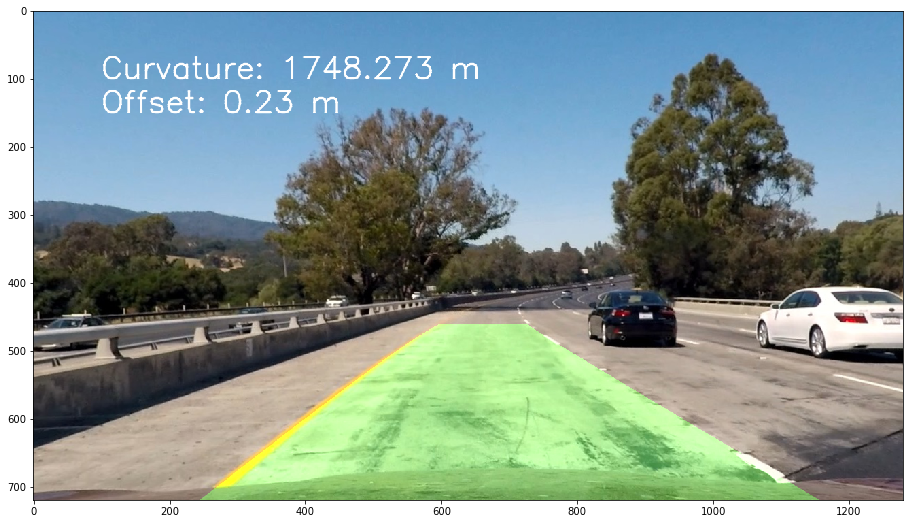

In [106]:
plt.figure(figsize=(16, 9))
LeftLine = Line(singleFrameMode=True)
RightLine = Line(singleFrameMode=True)
left_XS = []
right_XS = []
image = images[1]
undist = CamUndistort(image)    
mpimg.imsave('output_images/test1_undist.jpg', undist, format='jpg')
thresholded = Thresholding(undist)
mpimg.imsave('output_images/test1_th.jpg', thresholded, format='jpg')
roied = ROI(thresholded)
mpimg.imsave('output_images/test1_roi.jpg', roied, format='jpg')
warped, M = PerspectiveTransform(roied)
lc, rc, _ = FindPeakInSegment(warped)
print(lc, rc, rc-lc)
mpimg.imsave('output_images/test1_warped.jpg', warped, format='jpg')
TrackingLanes(warped, vis=False)    
#mpimg.imsave('output_images/test1_trackedLanes.jpg', undist, format='jpg')
result = DrawingLaneCarpet(warped, undist, M)
#mpimg.imsave('output_images/test1_final.jpg', result, format='jpg')

# Put together the Pipeline

In [102]:
cnt=0
def Pipeline(image):      
    global cnt
    #mpimg.imsave('project_video_input/frame_'+str(cnt).strip()+'.jpg', image, format='jpg')
    undist = CamUndistort(image)    
    thresholded = Thresholding(undist)
    roied = ROI(thresholded)
    warped, M = PerspectiveTransform(roied)
    TrackingLanes(warped, vis=False)    
    out = DrawingLaneCarpet(warped, undist, M, vis=False)
    if out is None:
        out = undist
    #mpimg.imsave('project_video_output/frame_'+str(cnt).strip()+'.jpg', out, format='jpg')
    cnt+=1
    return out

0 test3.jpg


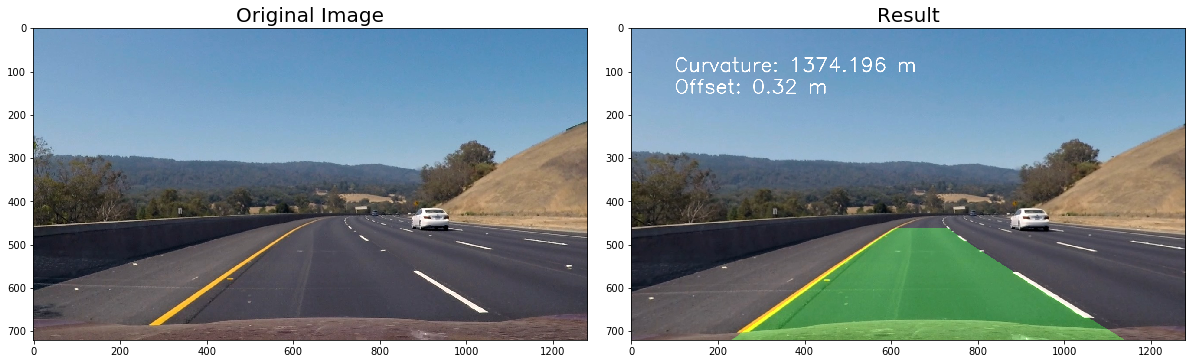

1 test1.jpg


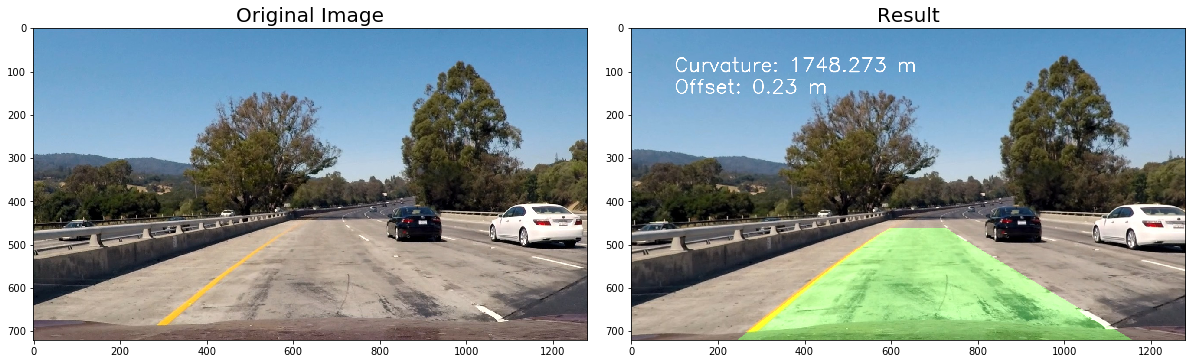

2 test5.jpg


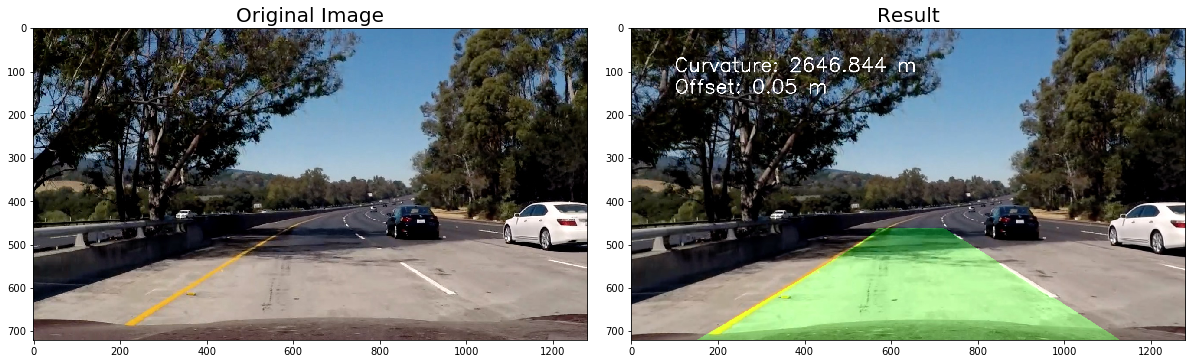

3 straight_lines2.jpg


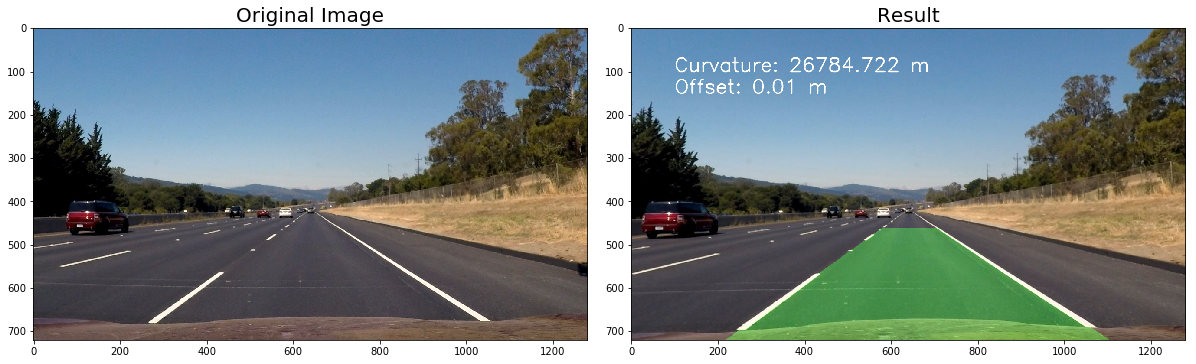

4 test4.jpg


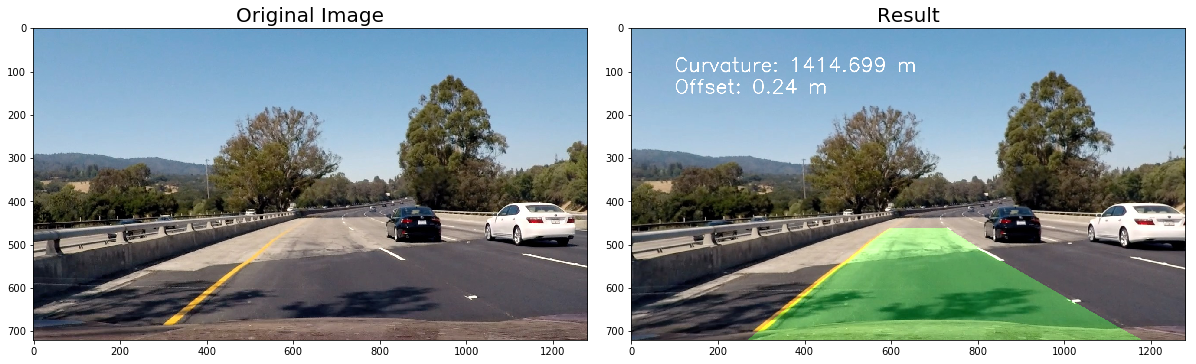

5 test2.jpg


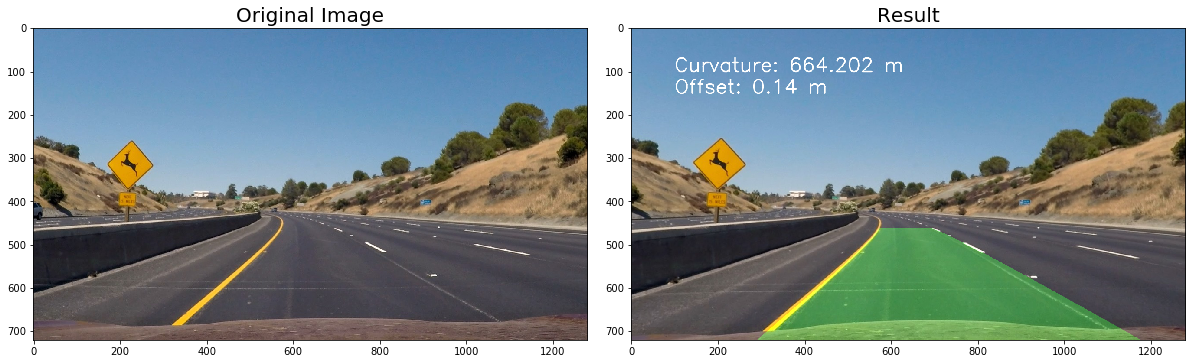

6 test6.jpg


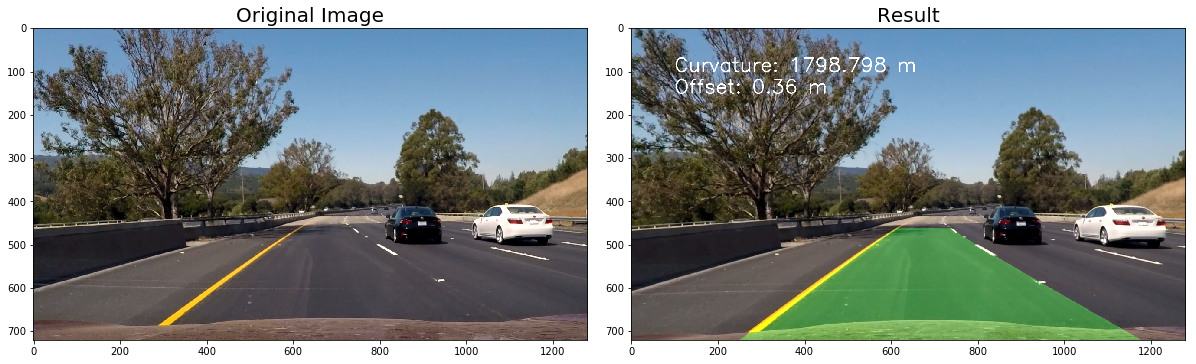

7 straight_lines1.jpg


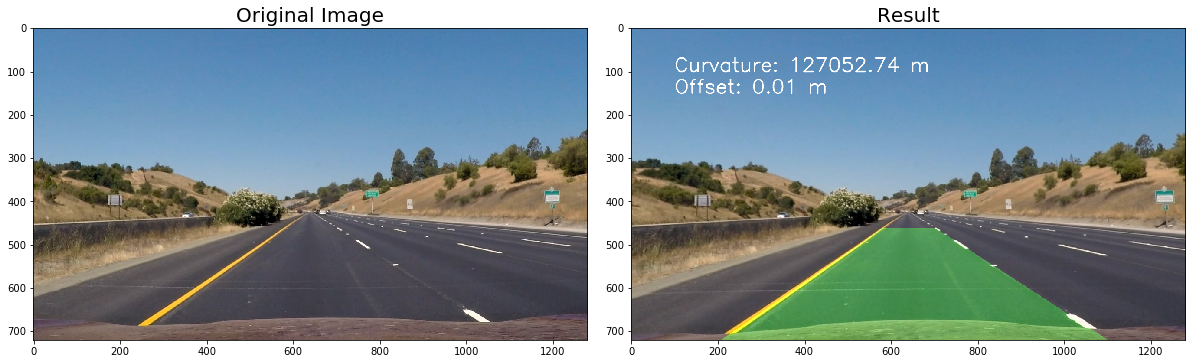

In [103]:
results=[]
LeftLine = Line(singleFrameMode=True)
RightLine = Line(singleFrameMode=True)
for i in range(len(images)):
    image = images[i]
    print(i, fns[i])
    result = Pipeline(image)
    mpimg.imsave('output_images/'+fns[i], result, format='jpg')
    results.append(result)    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(result)
    ax2.set_title('Result', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

# Processing Video

In [104]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [105]:
clip_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
LeftLine = Line(singleFrameMode=False)
RightLine = Line(singleFrameMode=False)
left_XS = []
right_XS = []
cnt=0
Parameters = GetParameters()
print(Parameters)
processor = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
%time processor.write_videofile(clip_output, audio=False)

{'CameraCalibrationFile': './cam_calib.p', 's_thresh': (170, 255), 'h_thresh': (42, 80), 'sx_thresh': (20, 100), 'Perspect_hx1': 548, 'Perspect_hx2': 736, 'Perspect_hy': 461, 'Perspect_offset': 200, 'ROI_hx1': 629, 'ROI_hx2': 680, 'ROI_bx1': 0, 'ROI_bx2': 1269, 'ROI_hy': 419, 'Fit_MinPoints': 150, 'Fit_ClearOut': (500, 800), 'Fit_MinCurvature': 500, 'Fit_PositionTolerence': 100, 'Fit_WidthTolerence': 100, 'Fit_WindowSize': 10, 'Fit_ValueThreshold': 0.02, 'Fit_std': 0.05}
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [07:21<00:00,  2.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 15min 10s, sys: 1min 53s, total: 17min 4s
Wall time: 7min 22s


In [107]:
clip_output = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

# Challenge Video

In [112]:
cnt=0

Parameters = {'CameraCalibrationFile': './cam_calib.p',
                's_thresh':(80, 255),  #G
                'h_thresh':(42, 80),  #B
                'sx_thresh':(20, 100), #R
                'Perspect_hx1': 584, 
                'Perspect_hx2': 721, 
                'Perspect_hy': 470, #the y of the horizon
                'Perspect_offset': 200,
                'ROI_hx1': 640, 
                'ROI_hx2': 730,
                'ROI_bx1': 200, 
                'ROI_bx2': 1100,
                'ROI_hy':470,              
                'Fit_ClearOut': (500, 900),
                'Fit_MinPoints': 150,
                'Fit_MinCurvature': 100,
                'Fit_PositionTolerence': 150,
                'Fit_WidthTolerence': 100,
                'Fit_WindowSize': 10,
                'Fit_ValueThreshold': 0.02,
                'Fit_std': 0.05
             }

def equalizeHistColor(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    image_out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return image_out

def Pipeline_cv(image):      
    global cnt
    #mpimg.imsave('challenge_video_input/frame_'+str(cnt).strip()+'.jpg', image, format='jpg')
    undist = CamUndistort(image)    
    undist = equalizeHistColor(undist)
    thresholded = Thresholding(undist)
    roied = ROI(thresholded)
    warped, M = PerspectiveTransform(roied)
    TrackingLanes(warped, vis=False)    
    out = DrawingLaneCarpet(warped, undist, M, vis=False, font_color=(0,0,0))
    if out is None:
        out = undist
    mpimg.imsave('challenge_video_output/frame_'+str(cnt).strip()+'.jpg', out, format='jpg')
    cnt+=1
    return out

## Parameter Tuning Part

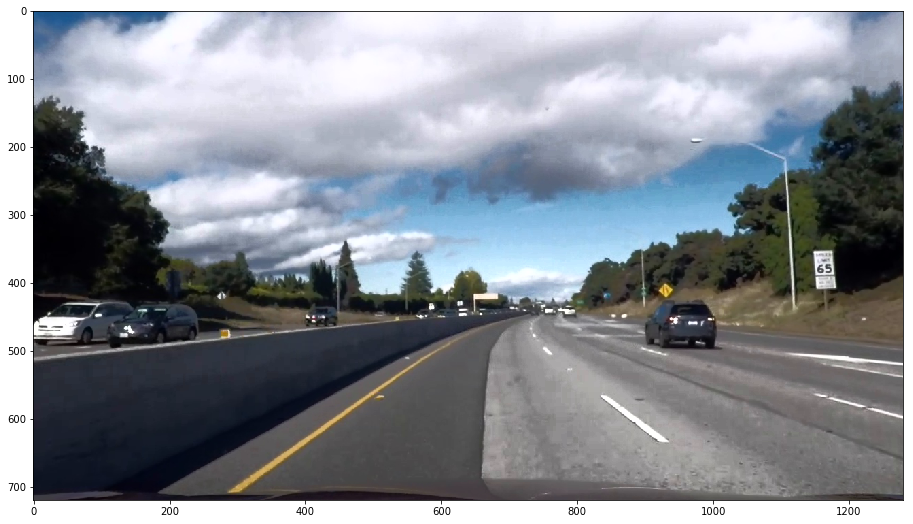

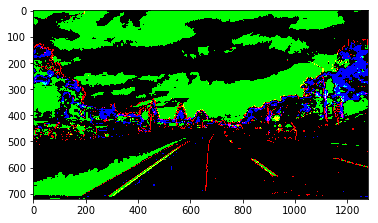

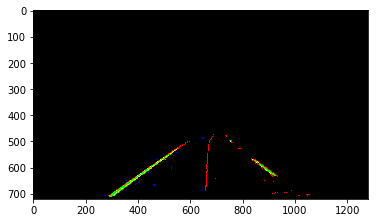

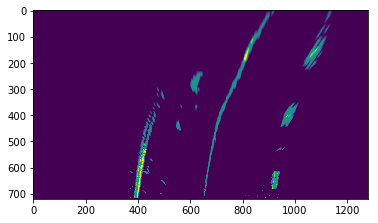

Estimated width (pixel): 530 Left Curvature: 256.698958801 m Right Curvature: 425.52437278 m


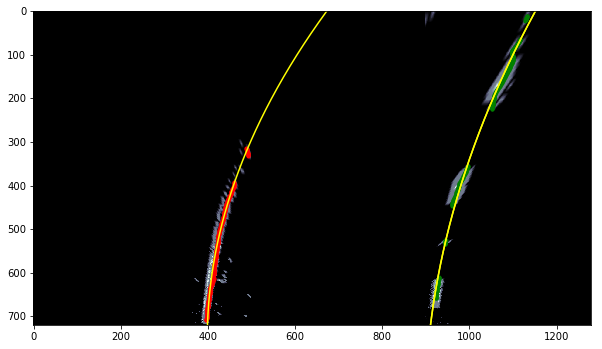

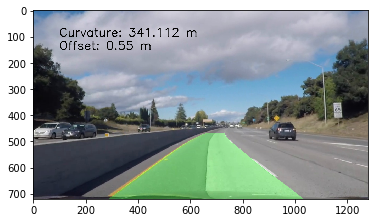

In [114]:
plt.figure(figsize=(16, 9))
LeftLine = Line(singleFrameMode=True)
RightLine = Line(singleFrameMode=True)
left_XS = []
right_XS = []
image = image = mpimg.imread('challenge_video_input/frame_265.jpg')
undist = CamUndistort(image)    
equalized = equalizeHistColor(undist)
plt.imshow(equalized)
plt.show()

thresholded = Thresholding(equalized)
plt.imshow(thresholded)
plt.show()

#mpimg.imsave('output_images/test1_th.jpg', thresholded, format='jpg')
roied = ROI(thresholded)

plt.imshow(roied)
plt.show()

#mpimg.imsave('output_images/test1_roi.jpg', roied, format='jpg')
warped, M = PerspectiveTransform(roied)

plt.imshow(warped)
plt.show()

#mpimg.imsave('output_images/test1_warped.jpg', warped, format='jpg')
TrackingLanes(warped, vis=True)    
plt.show()
result = DrawingLaneCarpet(warped, undist, M, vis=True, font_color=(0,0,0))

In [115]:
clip_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
LeftLine = Line(singleFrameMode=False)
RightLine = Line(singleFrameMode=False)
left_XS = []
right_XS = []
cnt=0
processor = clip2.fl_image(Pipeline_cv) #NOTE: this function expects color images!!
%time processor.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



100%|██████████| 485/485 [03:26<00:00,  2.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 7min 44s, sys: 49 s, total: 8min 33s
Wall time: 3min 26s
